# Dataset Statistics for Disease Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel

# Read Full Sentence Table

The cells below will read every sentence that contains a gene and disease entity from the sentence table in our postgres database. For time sake majority of the data has already been processed and save as files mentioned below.

In [ ]:
sql = '''
select id, text, (
    char_length(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g')) - 
    char_length(regexp_replace(regexp_replace(CAST(words AS TEXT), '[\u0080-\u00ff]', '', 'g'), ',', '','g'))
) as sen_length, entity_cids, entity_types 
from sentence 
where entity_types::text like '%%Gene%%' or entity_types::text like '%%Disease%%';
'''
sentence_df = pd.read_sql(sql, database_str)
sentence_df.head(2)

In [ ]:
entity_counts = Counter()
for index, row in tqdm_notebook(sentence_df.iterrows()):
    entity_counts.update([x for x in row['entity_cids'] if x!='O'])
entity_stats_df = pd.DataFrame.from_dict(records).fillna(0)
entity_stats_df.to_csv("data/entity_stats.tsv.xz", sep="\t",  index=False, compression="xz")

In [ ]:
sentence_df[["id", "text", "sen_length"]].to_csv("data/sentence_stats.tsv.xz", sep="\t", index=False, compression="xz")

# Sentence Counts and Statistics

Below is the block of code that contains information about the full distribution of sentences tied to each candidate pair. Multiple sentences can contain more than one co-occuring pair, which results in some sentences being counted more than once.

## Load and Merge DataFrames

In [5]:
entity_level_df = pd.read_csv("../disease_gene_pairs_association.csv.xz")
entity_level_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0


In [6]:
entity_stats_df = pd.read_table("data/entity_stats.tsv.xz")
entity_stats_df.head(2)

,Compound,Disease,Gene,sentence_id
0,0.0,0.0,1.0,45054325
1,0.0,1.0,0.0,45056191


In [7]:
sentence_count_df = pd.read_table("data/sentence_stats.tsv.xz").rename(index=str, columns={"id":"sentence_id"})
sentence_count_df.head(2)

,sentence_id,text,sen_length
0,45054325,"Nucleolin, a major nucleolar protein, is found...",16
1,45056191,"Also, LY293558, an alpha-amino-3-hydroxy-5-met...",28


In [8]:
sentence_sql = '''
select cand_id, "Disease_cid", "Gene_cid", sentence_id from (
select disease_gene.id as "cand_id", disease_gene."Disease_id",  disease_gene."Disease_cid", disease_gene."Gene_cid", candidate.split from disease_gene 
inner join candidate on disease_gene.id=candidate.id 
where split={}
) as candidate_splits inner join span on candidate_splits."Disease_id"=span.id;
'''

In [9]:
train_candidate_df = pd.read_sql(sentence_sql.format(0), database_str)
train_candidate_df.head(2)

,cand_id,Disease_cid,Gene_cid,sentence_id
0,21584,DOID:5408,5741,528427
1,21658,DOID:2355,3105,93123


In [10]:
dev_candidate_df = pd.read_sql(sentence_sql.format(1), database_str)
test_candidate_df = pd.read_sql(sentence_sql.format(2), database_str)

In [11]:
clean_up_df = lambda x: (
        entity_stats_df
        .merge(sentence_count_df, on="sentence_id")
        .merge(x, on="sentence_id")
        .rename(index=str, columns={
            "Disease":"Disease_mention_count", 
            "Gene":"Gene_mention_count", 
            "Compound":"Compound_mention_count",
            "cand_id": "candidate_id",
            "Disease_cid": "doid_id",
            "Gene_cid": "entrez_gene_id"
        })
        .astype({"entrez_gene_id": int})
    )

In [12]:
train_candidate_df = clean_up_df(train_candidate_df)
train_candidate_df.head(2)

,Compound_mention_count,Disease_mention_count,Gene_mention_count,sentence_id,text,sen_length,candidate_id,doid_id,entrez_gene_id
0,0.0,1.0,5.0,45056472,METHODS: AMs and CD(34)(+) T cells were isolat...,37,11949928,DOID:2841,947
1,0.0,2.0,1.0,45056438,[The study on correlation of c-myc gene expres...,21,11955336,DOID:10763,4609


In [13]:
dev_candidate_df = clean_up_df(dev_candidate_df)
test_candidate_df = clean_up_df(test_candidate_df)

In [14]:
training_set_df = (
    entity_level_df
    .query("split==0&has_sentence==1")
    .merge(
        train_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)
training_set_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,Compound_mention_count,Disease_mention_count,Gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,2.0,2.0,78840952,We revealed that A1BG and LRG1 were overexpres...,30,26725291
1,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0,0.0,3.0,1.0,86234572,METHODS: HEK293 cells expressing specific indi...,53,29874761


In [15]:
dev_set_df = (
    entity_level_df
    .query("split==1&has_sentence==1")
    .merge(
        dev_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)

test_set_df = (
    entity_level_df
    .query("split==2&has_sentence==1")
    .merge(
        test_candidate_df, 
        on=["entrez_gene_id", "doid_id"]
    )
)

In [16]:
total_candidates_df = (
    training_set_df
    .append(dev_set_df)
    .append(test_set_df)
)

## Distribution of Sentence Length

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


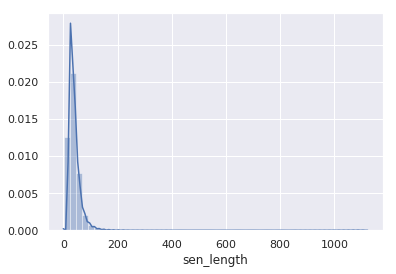

In [17]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [18]:
total_candidates_df["sen_length"].describe().astype(int)

count    3829908
mean          37
std           23
min            2
25%           23
50%           33
75%           46
max         1120
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of tokens for one given sentence is in the thousands range. Intuitively that doesn't make sense, since an average number of tokens for a given sentence is 37. Possible reason for this abnormality is parsing error. Lets take a look at this 1120 token sentence.

In [19]:
total_candidates_df.query("sen_length==1120").iloc[0]["text"]

'Pooled analysis of (R)-[11C]-verapamil PET data from two European centresM Bauer, M Feldmann, R Karch, W Wadsak, M Zeitlinger, MJ Koepp, M-C Asselin, E Pataraia, O LangerA13 In-vitro and in-vivo characterization of [18F]FE@SNAP and derivatives for the visualization of the melanin concentrating hormone receptor 1M Zeilinger, C Philippe, M Dumanic, F Pichler, J Pilz, M Hacker, W Wadsak, M MitterhauserA14 Reducing time in quality control leads to higher specific radioactivity of short-lived radiotracersL Nics, B Steiner, M Hacker, M Mitterhauser, W WadsakA15 In vitro 11C-erlotinib binding experiments in cancer cell lines with epidermal growth factor receptor mutationsA Traxl, Thomas Wanek, Kushtrim Kryeziu, Severin Mairinger, Johann Stanek, Walter Berger, Claudia Kuntner, Oliver LangerA16 7-[11C]methyl-6-bromopurine, a PET tracer to measure brain Mrp1 function: radiosynthesis and first PET evaluation in miceS Mairinger, T Wanek, A Traxl, M Krohn, J Stanek, T Filip, M Sauberer, C Kuntner,

The above uspicion was correct. This is a parsing error where the list of authors are combined with the title of their work for a winter symposium. The following can be found at this id link: [27090254](https://www.ncbi.nlm.nih.gov/pubmed/27090254). The goal here is to take these parsing errors into account and determine an optimal cutoff point for these sentences. Using common statsitic rules any point that is greater than two standard deviations away from the mean will be removed.

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


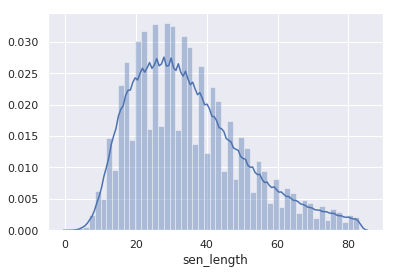

In [20]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [21]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    3683067
mean          34
std           15
min            2
25%           23
50%           32
75%           44
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 3.6 million. (removed 146841 sentences).

In [22]:
before_filter = set([tuple(line) for line in total_candidates_df[["entrez_gene_id", "doid_id"]].values])
after_filter = set([tuple(line) for line in total_candidates_df.query("sen_length < 83+1")[["entrez_gene_id", "doid_id"]].values])
print(
    "Total number of entity candidates before filter: {}".format(
        total_candidates_df[["entrez_gene_id", "doid_id"]].drop_duplicates().shape[0]
    )
)
print("Total number of entity candidates being thrown out: {}".format(len(before_filter.difference(after_filter))))

Total number of entity candidates before filter: 160222
Total number of entity candidates being thrown out: 4103


In [23]:
filtered_total_candidates_df = total_candidates_df.query("sen_length < 83+1")

Text(0.5,1,'# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet')

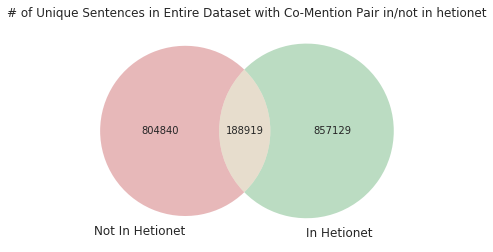

In [24]:
venn2(
    [
        set(filtered_total_candidates_df.query("hetionet==0").sentence_id),
        set(filtered_total_candidates_df.query("hetionet==1").sentence_id)
    ], set_labels=["Not In Hetionet", "In Hetionet"])
plt.title("# of Unique Sentences in Entire Dataset with Co-Mention Pair in/not in hetionet")

# Co-occuring Mentions Sentence Stats

This next block contains a visualization about the number of mentions a sentence may contain.

Text(0.5,1,'Mention Distribution of Entire Dataset')

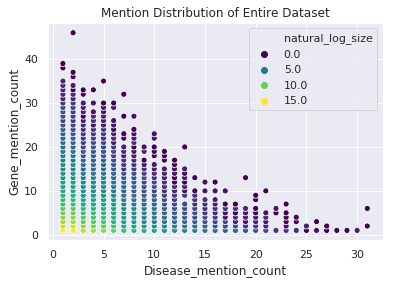

In [25]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Mention Distribution of Entire Dataset")

In the above graph every point is group of possible mention counts sentences could contain. For example one group has sentences containing one gene mention and one disease mention (indicated in the bottom left in yellow). Overall this graph is acceptable in terms of the spread between mentions; however, when getting ready to train the deep learning models one has to make sure the algorithm can detect which co-mention pair the candidate is referring to.

# Subsampled Set Distributions

Take a look at the stratification for each train/dev/test set.

## Training Set

Here the training set covers majority of the characterisitics are the entire dataset. This isn't surprising because a stratified sort was used to allocate candidates.

Text(0.5,1,'Distribution of Sentences in Subsampled Training Set')

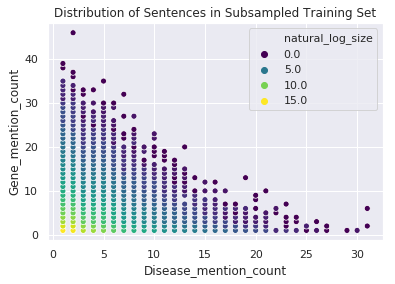

In [26]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==0")
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Distribution of Sentences in Subsampled Training Set")

## Dev Set

This block contains information on the development set (aka tuning set).

Text(0.5,1,'Sentence Distribution of Total Dev Dataset')

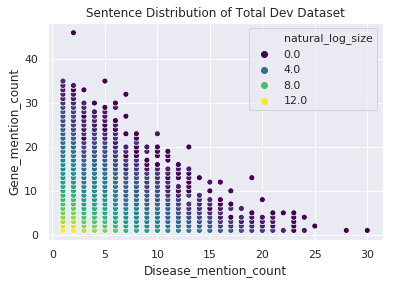

In [27]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==1")
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Dev Dataset")

In [28]:
dev_dataset_df = pd.read_excel("sentence_labels_dev.xlsx").query("curated_dsh.notnull()")

In [29]:
dev_candidates_stats_df = (
    filtered_total_candidates_df
    .query("split==1")
    .merge(dev_dataset_df[["candidate_id", "curated_dsh"]], on="candidate_id")
)
print("Total number of positives (1) and negatives (0): \n{}".format(dev_candidates_stats_df.curated_dsh.value_counts()))

Total number of positives (1) and negatives (0): 
0.0    459
1.0    283
Name: curated_dsh, dtype: int64


Text(0.5,1,'Sentence Distribution of Hand Labeled Dev Dataset')

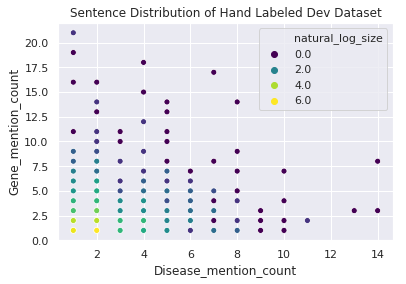

In [30]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        dev_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Hand Labeled Dev Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


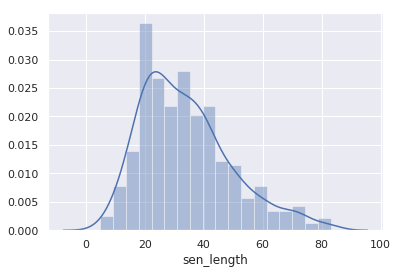

In [31]:
sns.distplot(dev_candidates_stats_df["sen_length"], rug=False)

## Test Set

Text(0.5,1,'Sentence Distribution of Total Test Dataset')

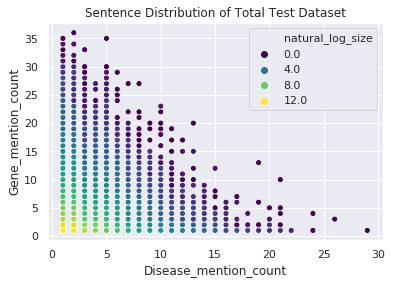

In [32]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        filtered_total_candidates_df
        .query("split==2")
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Total Test Dataset")

In [33]:
test_dataset_df = pd.read_excel("sentence_labels_test.xlsx").query("curated_dsh.notnull()")

In [34]:
test_candidates_stats_df = (
    filtered_total_candidates_df
    .query("split==2")
    .merge(test_dataset_df[["candidate_id", "curated_dsh"]], on="candidate_id")
)
print("Total number of positives (1) and negatives (0): \n{}".format(test_candidates_stats_df.curated_dsh.value_counts()))

Total number of positives (1) and negatives (0): 
0.0    617
1.0    346
Name: curated_dsh, dtype: int64


Text(0.5,1,'Sentence Distribution of Hand Labeled Dev Dataset')

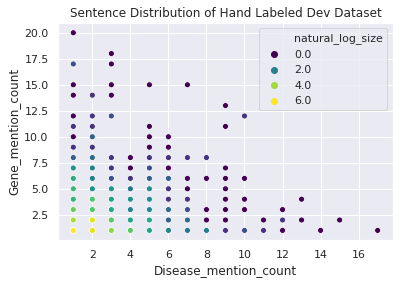

In [35]:
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        test_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Hand Labeled Dev Dataset")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


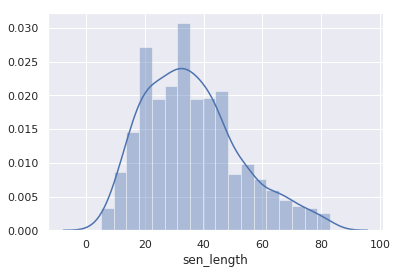

In [36]:
sns.distplot(test_candidates_stats_df["sen_length"], rug=False)

In conclusion, it is important to analyze one's dataset before undergoing the journey of training deep learning model.  Sentence length is an important cutoff, when it comes to filtering the dataset; otherwise, a significant amount of problems will arise when it comes to training machine learning algorithms. Optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance.